In [1]:
#####
# For testing how the mamba package works.
#

In [2]:
import os
from glob import glob
import pandas as pd 
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")



/home/whalenlex/.local/share/virtualenvs/mamba-segment-2sIU9SJh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    print(masks_paths)

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [4]:
data_path = "../datasets/lgg-mri-segmentation/kaggle_3m"
df = create_df(data_path)
train_df, val_df, test_df = split_df(df)

['../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_25_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_46_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_57_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_48_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_11_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_33_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_38_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_18_mask.tif', '../datasets/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19

In [5]:
train_df.iloc[1]

images_paths    ../datasets/lgg-mri-segmentation/kaggle_3m/TCG...
masks_paths     ../datasets/lgg-mri-segmentation/kaggle_3m/TCG...
Name: 2215, dtype: object

In [6]:
print('Train\t', train_df.shape, '\nVal\t', val_df.shape, '\nTest\t', test_df.shape)

Train	 (3143, 2) 
Val	 (393, 2) 
Test	 (393, 2)


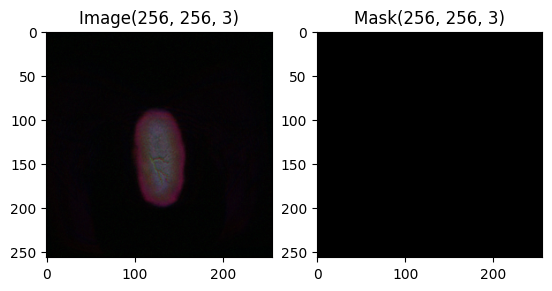

In [8]:
image = cv2.imread(train_df.iloc[3, 0]) / 255.0
mask = cv2.imread(train_df.iloc[3, 1]) / 255.0
mask = np.where(mask>=0.5, 1., 0.)

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Image'+str(image.shape))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask'+str(mask.shape))
plt.show()

In [24]:
class Brain_mri_dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe  ,  transform = None ,  mask_transform= None):
        self.df = dataframe #pd.read_csv(annotations_file)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        image = cv2.imread(self.df.iloc[idx, 0]) / 255.0
        mask = cv2.imread(self.df.iloc[idx, 1])  / 255.0
        mask = np.where(mask>=0.5, 1., 0.)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [25]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

train_data = Brain_mri_dataset(train_df, transform = transform_ ,  mask_transform= transform_)
val_data = Brain_mri_dataset(val_df, transform = transform_ ,  mask_transform= transform_)
test_data = Brain_mri_dataset(test_df, transform = transform_ ,  mask_transform= transform_)

batch_size = 64

train_dataloader = DataLoader(train_data, batch_size = batch_size , shuffle = True)
val_dataloader = DataLoader(val_data, batch_size = batch_size , shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size , shuffle = True)



In [26]:
print('Training batches\t', len(train_dataloader))
print('Validation batches\t', len(val_dataloader))
print('Test batches\t\t', len(test_dataloader))

Training batches	 50
Validation batches	 7
Test batches		 7


In [27]:
img_sample, msk_sample = next(iter(val_dataloader))
print(img_sample.shape, '\t', img_sample.dtype)
print(msk_sample.shape, '\t', msk_sample.dtype)

torch.Size([64, 3, 256, 256]) 	 torch.float64
torch.Size([64, 3, 256, 256]) 	 torch.float64


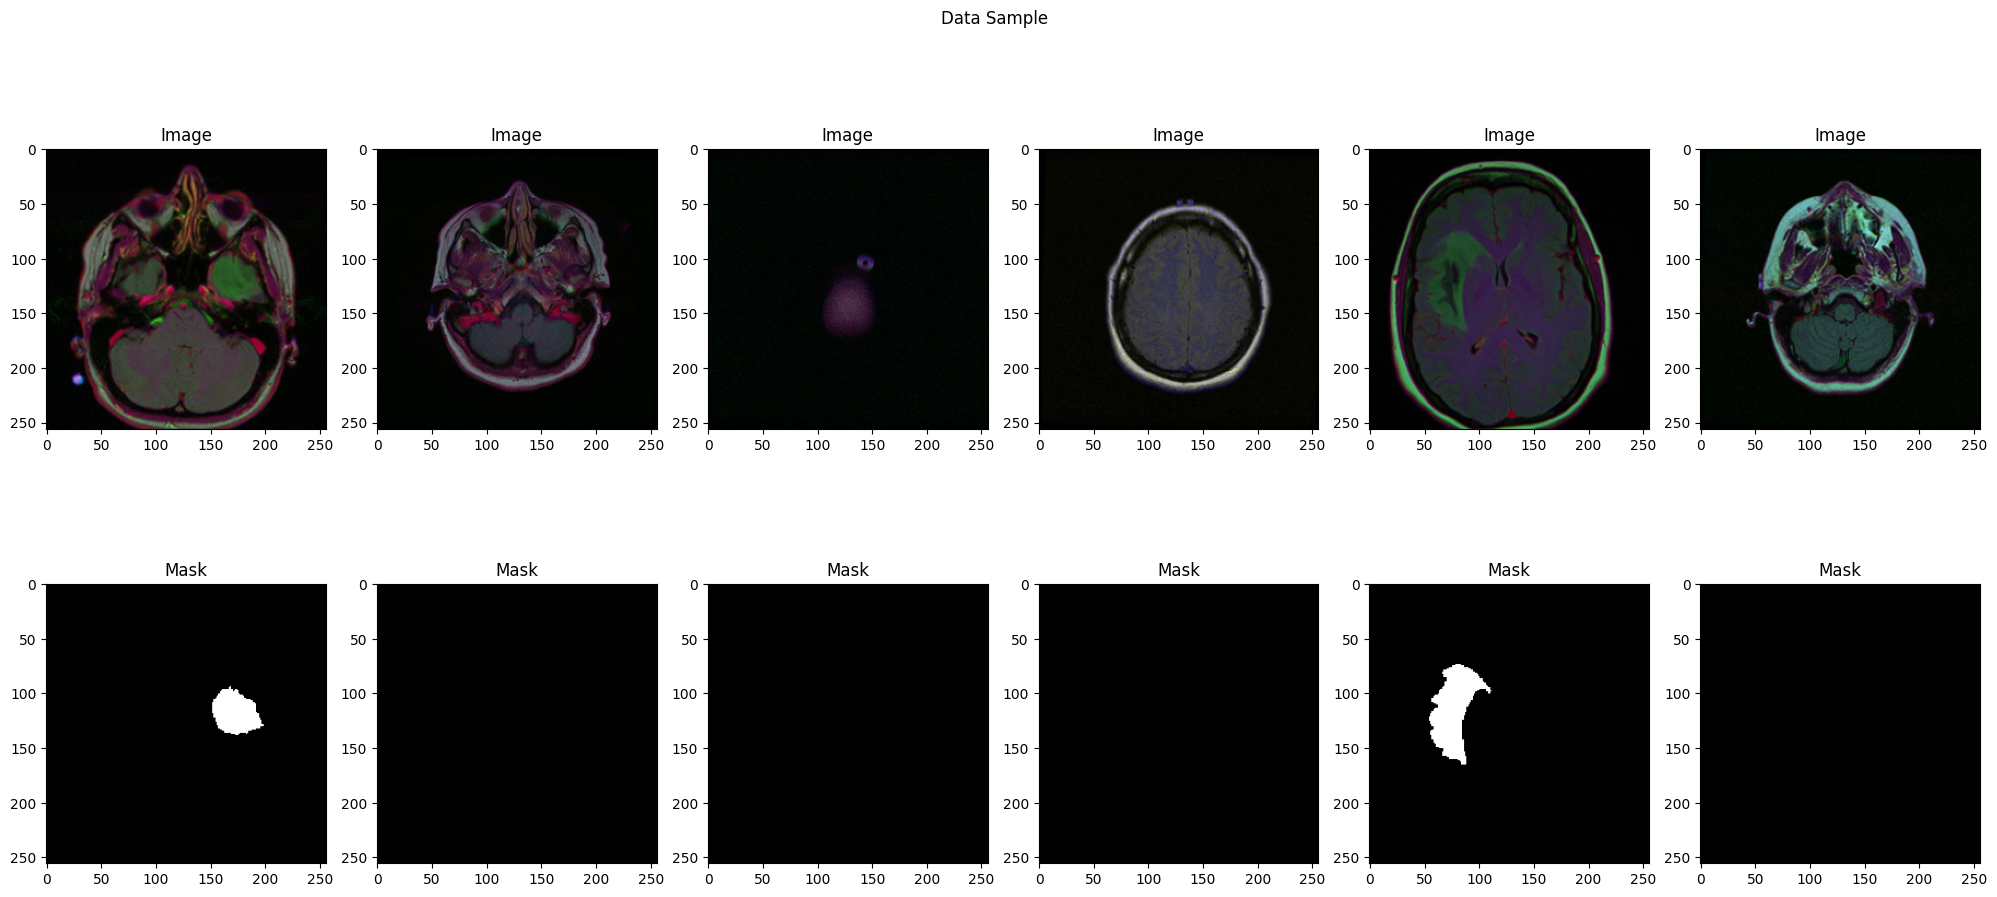

In [28]:
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i in range(6):
  axs[0, i].imshow(img_sample[i].permute(1,2,0))
  axs[0, i].set_title("Image")

  axs[1, i].imshow(msk_sample[i].permute(1,2,0))
  axs[1, i].set_title("Mask")
fig.suptitle('Data Sample')
fig.tight_layout()
fig.show()

In [29]:
class UNet(nn.Module):
   def __init__(self):
       super(UNet, self).__init__()

       # Encoder
       self.encoder1 = nn.Sequential(
           nn.Conv2d(3, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True),
           nn.Conv2d(32, 32, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(32),
           nn.ReLU(inplace=True)
       )
       self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder2 = nn.Sequential(
           nn.Conv2d(32, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True),
           nn.Conv2d(64, 64, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(64),
           nn.ReLU(inplace=True)
       )
       self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder3 = nn.Sequential(
           nn.Conv2d(64, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True),
           nn.Conv2d(128, 128, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(128),
           nn.ReLU(inplace=True)
       )
       self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
       self.encoder4 = nn.Sequential(
           nn.Conv2d(128, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.ReLU(inplace=True)
       )
       self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


       # Bottleneck
       self.bottleneck = nn.Sequential(
           nn.Conv2d(256, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
           nn.Conv2d(512, 512, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(512),
           nn.ReLU(inplace=True),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
       )

       # Decoder
       self.upconv4 = nn.Sequential(
           nn.ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder4 = nn.Sequential(
           nn.Conv2d(512, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh(),
           nn.Conv2d(256, 256, kernel_size=(3, 3), padding=(1, 1)),
           nn.BatchNorm2d(256),
           nn.Tanh()
       )
       self.upconv3 = nn.Sequential(
           nn.ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder3 = nn.Sequential(
           nn.Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv2 = nn.Sequential(
           nn.ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder2 = nn.Sequential(
           nn.Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.upconv1 = nn.Sequential(
           nn.ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2)),
          #  nn.MaxPool2d(kernel_size=2, stride=2)
           )
       self.decoder1 = nn.Sequential(
           nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh(),
           nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
           nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
           nn.Tanh()
           )
       self.conv = nn.Sequential(
           nn.ConvTranspose2d(32, 3, kernel_size=(1, 1), stride=(1, 1)),
           nn.Sigmoid()
           )

   def forward(self, x):
        #Encoder
       encoder1 = self.encoder1(x)
       encoder2 = self.encoder2(self.pool1(encoder1))
       encoder3 = self.encoder3(self.pool2(encoder2))
       encoder4 = self.encoder4(self.pool3(encoder3))

       # Bottleneck
       bottleneck = self.bottleneck(self.pool4(encoder4))

       #Decoder & Connections
       x = self.upconv4(bottleneck)
      #  print(encoder4.shape); print(x.shape);
       x = torch.cat([x, encoder4], dim=1)
      #  print(x.shape);
       x = self.decoder4(x)
      #  print(x.shape);

       x = self.upconv3(x)
       x = torch.cat([x, encoder3], dim=1)
       x = self.decoder3(x)
      #  print(x.shape);

       x = self.upconv2(x)
       x = torch.cat([x, encoder2], dim=1)
       x = self.decoder2(x)
      #  print(x.shape);


       x = self.upconv1(x)
       x = torch.cat([x, encoder1], dim=1)
       x = self.decoder1(x)
      #  print(x.shape);

       x = self.conv(x)
      #  print(x.shape);

       return x #(x >= 0.6).float()


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [38]:
device = torch.device('cpu')

In [39]:
model = UNet().to(device)
model

UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fa

In [40]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 7765603
Trainable parameters: 7765603


In [41]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, logits, targets):
        smooth = 100
        num = targets.size(0)
        probs = torch.sigmoid(logits)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2).sum()

        return 1 - ((2. * intersection + smooth) / (m1.sum() + m2.sum() + smooth))


In [42]:
def IOU(y_true, y_pred, smooth=100):
    intersection = (y_true * y_pred).sum()
    sum = (y_true + y_pred).sum()
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [43]:
learning_rate = 0.01

criterion = DiceLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)


In [44]:
epochs=24

train_loss=[]
val_loss = []
trainIOU = []
valIOU = []

for epoch in range(epochs):

  total_train_loss=0
  total_val_loss=0
  # training mode
  model.train()
  total_train_iou = 0.0
  for img,label in train_dataloader:
    # print(img.shape)
    img, label =img.to(device).float(),label.to(device).float()
    optimizer.zero_grad()
    pred = model(img)
    loss = criterion(pred,label)
    total_train_loss+=loss.item()
    iou = IOU(label, pred)
    total_train_iou += iou.item()
    loss.backward()
    optimizer.step()
  train_iou = total_train_iou / (len(train_dataloader)+1)
  trainIOU.append(train_iou)
  train_loss.append(total_train_loss/(len(train_dataloader)+1))

  # validation mode
  model.eval()
  total_val_iou = 0.0
  with torch.no_grad():
    for image,label in val_dataloader:
      image, label = image.to(device).float(), label.to(device).float()
      pred = model(image)
      loss = criterion(pred, label)
      total_val_loss += loss.item()
      iou = IOU(label, pred)
      total_val_iou += iou.item()

    val_iou = total_val_iou / (len(val_dataloader) + 1)
    valIOU.append(val_iou)
    total_val_loss = total_val_loss / (len(val_dataloader) + 1)
    val_loss.append(total_val_loss)

  print('Epoch: {}/{},\tTrain Loss: {:.4f},\tTrain IOU: {:.4f},\tVal Loss: {:.4f},\tVal IOU: {:.4f}'.format(epoch+1, epochs, total_train_loss, train_iou, total_val_loss, val_iou))

  # return train_loss, val_loss, val_acc

KeyboardInterrupt: 

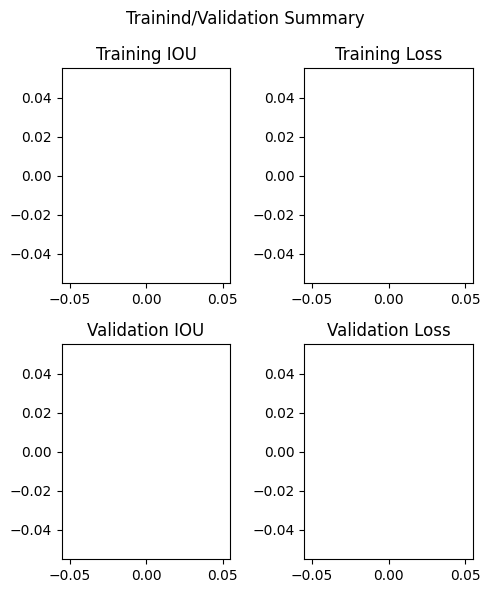

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(5, 6))

axs[0, 0].plot(trainIOU, c='blue')
axs[0, 0].set_title("Training IOU")

axs[0, 1].plot(train_loss, c='red')
axs[0, 1].set_title("Training Loss")

axs[1, 0].plot(valIOU, c='blue')
axs[1, 0].set_title("Validation IOU")

axs[1, 1].plot(val_loss, c='red')
axs[1, 1].set_title("Validation Loss")

fig.suptitle('Trainind/Validation Summary')
fig.tight_layout()
fig.show()
